In [ ]:
!pip install pandas==2.2.2 openai pymongo pypdf langchain_community tqdm tenacity scikit-learn tiktoken python-dotenv seaborn qdrant-client fastembed==0.1.1 --upgrade

# **RAG System with MongoDB as vector search engine**

## **1. Parsing and tokenizing the pdf**

## Method 1 : Parsing by using headers contained in the pdf.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# The url for the user manual pdf.
url = "https://raw.githubusercontent.com/MatthewHsu1/RAGsystemOpenAI/main/F80_F83_F85_OM_810.pdf"

# Initialize PyPDFLoader with downloaded user manual pdf
loader = PyPDFLoader(url)
pages = loader.load_and_split()

In [ ]:
# First create a dictionary of headers to parse the pdf by headers.

headers = [
    "TABLE OF CONTENTS",
    "PRODUCT REGISTRATION",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "IMPORTANT ELECTRICAL INSTRUCTIONS",
    "GROUNDING INSTRUCTIONS",
    "IMPORTANT OPERATION INSTRUCTIONS",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "PREVENTATIVE MAINTENANCE CHART",
    "F80 / F83 / F83 ASSEMBLY PACK CHECKLIST",
    "F80 / F83 / F83 ASSEMBLY INSTRUCTIONS",
    "FOLDING INSTRUCTIONS",
    "TRANSPORTATION INSTRUCTIONS",
    "OPERATION OF YOUR TREADMILL",
    "GETTING STARTED",
    "QUICK-START OPERATION",
    "PAUSE/STOP/RESET FEATURE",
    "INCLINE FEATURE",
    "DOT MATRIX CENTER DISPLAY",
    "PROGRAMMABLE FEATURES",
    "HEART RATE PROGRAMS",
    "USING HEART RATE TRANSMITTER",
    "GENERAL MAINTENANCE",
    "BELT ADJUSTMENTS",
    "TREAD-BELT TRACKING ADJUSTMENT",
    "BELT/DECK LUBRICATION",
    "SERVICE CHECKLIST - DIAGNOSIS GUIDE",
    "MANUFACTURER’S LIMITED WARRANTY"
]

In [ ]:
import re

def strip_top(page):
  """
    Every document inside the variable of pages has this string in the beginning, 'F80 /  F83 / F85 TREADMILL'.
    Therefore, the real content of the pdf begins after that string.
  """
  pattern = r"F80 /  F83 / F85 TREADMILL(.*)"
  for page in pages:
    match = re.search(pattern, page.page_content, re.DOTALL)

    clean_text = ""
    if match:
        clean_text = match.group(1).strip()
        clean_text = clean_text.replace("\n", " ")
        clean_text = clean_text.replace("\x84", "")
        clean_text = re.sub(r'\s+', ' ', clean_text)
        page.page_content = clean_text
    else:
      clean_text = page.page_content.replace("\n", " ")
      clean_text = clean_text.replace("\x84", "")
      clean_text = re.sub(r'\s+', ' ', clean_text)
      page.page_content = clean_text

In [ ]:
# The pdf is in plain text
strip_top(pages)

In [ ]:
import re

def split_by_header(headers, pages):

  list_of_string = []
  for page in pages:

    # Create a regular expression that pattern matches all strings in headers.
    pattern = '|'.join(map(re.escape, headers))

    # Split each page by the pattern created.
    split_result = re.split(pattern, page.page_content)

    # Get rid of any empty strings
    split_result = [s.strip() for s in split_result if s.strip() != '']

    list_of_string += split_result

  return list_of_string

In [ ]:
text = split_by_header(headers, pages)

### Check to see if any string in the list has the possibility to exceed the text embedding token limit.

In [ ]:
for string in text:
  word_count = len(string.split())
  assert (word_count <= 5500) == True, "A string may potentially exceed the token limit"

## Method 2 : Using RecursiveCharacterTextSplitter from Langchain that has a sliding window for text overlap.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# The url for the user manual pdf.
url = "https://raw.githubusercontent.com/MatthewHsu1/RAGsystemOpenAI/main/F80_F83_F85_OM_810.pdf"

# Initialize PyPDFLoader with downloaded user manual pdf
loader = PyPDFLoader(url)
pages = loader.load_and_split()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter (
    chunk_size = 512,
    chunk_overlap = 100
)

text = ""

for page in pages:
  text += page.page_content

docs = text_splitter.create_documents([text])

text = []
for doc in docs:
  text.append(doc.page_content)

### Convert the list 'text' into a panda dataframe.

In [ ]:
import pandas as pd

dataset_df = pd.DataFrame(text)
dataset_df.columns = ['text']

## **2. Transform the pdf into vector embeddings and store it inside of MongoDB**

### This method will take a text and get an vector embedding from OpenAI.

In [ ]:
import openai
from google.colab import userdata
from tqdm import tqdm

tqdm.pandas()

openai.api_key = userdata.get('open_ai')

EMBEDDING_MODEL = 'text-embedding-3-small'

# Returns the vector embedding of a text
def get_embedding(text):
  if not text or not isinstance(text, str):
    return None

  try:
    embedding = openai.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding
    return embedding
  except Exception as e:
    print(f'Error in get_embedding: {e}')
    return None

# Apply vector embedding to a the dataframe
dataset_df['embedding'] = dataset_df['text'].progress_apply(get_embedding)

dataset_df.head()

### This method will connect to mongoDB and get a client instance.

In [ ]:
import pymongo
from google.colab import userdata

def get_mongo_client(mongo_uri):
  try:
    client = pymongo.MongoClient(mongo_uri)
    print('Connection to MongoDB successful')
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f'Connection failed: {e}')
    return None

mongo_uri = userdata.get('mongo_url')
if not mongo_uri:
  print('Mongo_uri not set in envirnment variables')

mongo_client = get_mongo_client(mongo_uri)

# Varaibles that represent the database name, and collection name
database = "Treadmill"
collection = "F80_F83_F85_recursive_chunking"

db = mongo_client[database]
collection = db[collection]

# Convert pandas dataframe into json format
documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print('Data ingestion into MongoDB completed')

Connection to MongoDB successful
Data ingestion into MongoDB completed


## **3. Query answers by providing relevent context from the pdf inside the prompt**

### Set up openAI API key

In [115]:
import openai
from google.colab import userdata

openai.api_key = userdata.get('open_ai')

### This method will connect to mongoDB and get a client instance.

In [116]:
import pymongo
from google.colab import userdata

def get_mongo_client(mongo_uri):
  try:
    client = pymongo.MongoClient(mongo_uri)
    print('Connection to MongoDB successful')
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f'Connection failed: {e}')
    return None

mongo_uri = userdata.get('mongo_url')
if not mongo_uri:
  print('Mongo_uri not set in envirnment variables')

mongo_client = get_mongo_client(mongo_uri)

# Varaibles that represent the database name, and collection name
database = "Treadmill"
collection = "F80_F83_F85_recursive_chunking"

db = mongo_client[database]
collection = db[collection]

Connection to MongoDB successful


### Given a user query, this method will search the mongoDB for the top 10 most relevent text chunks from the pdf.

In [117]:
def vector_search(user_query, collection):
  query_embedding = get_embedding(user_query)

  if query_embedding is None:
    return "Invalid query or embedding generation failed."

  pipeline = [
      {
          "$vectorSearch": {
              "index": "vector_index",
              "queryVector": query_embedding,
              "path": "embedding",
              "numCandidates": 10,
              "limit": 5
          }
      },
      {
          "$project": {
              "text":1,
              "score": {
                  "$meta": "vectorSearchScore"
              }
          }
      }
  ]

  results = collection.aggregate(pipeline)
  return list(results)

### Construct the user prompt with chain of thought process.

In [118]:
def handle_user_query(query, collection):
  get_knowledge = vector_search(query, collection)

  search_result = ''
  for result in get_knowledge:
    search_result += f"Instruction: {result.get('text', 'N/A')}.\n"

  completion = openai.chat.completions.create(
      model='gpt-3.5-turbo',
      temperature=0.1,
      messages=[
          {'role': "system", 'content': 'You are a treadmill technician that provides technical details with the context given.'},
          {'role': 'user', 'content':
            'Context: ' + search_result + '\n\n' +
            'Question: ' + query + '\n\n' +
            'State each step and then show your work for performing that step. \n\n' +
            'steps: \n' +
                    '- what facts do you need to look for in the text to answer the question? \n' +
                    '- Does the text contain all the facts needed to answer the question? \n' +
                    '- Think about how you might answer the question given what you know. \n\n' +
            'Finally, answer the Question and prefix your answer with <Response>."'
          }
      ]
  )

  return (completion.choices[0].message.content)

## **4. We want an assistant that uses the built-in file retrieval function from OpenAI. Then, we want a second assistant to validate responses from both MongoDB RAG and the assistant's file search.**

### Function to create a thread instance from OpenAI.

In [119]:
def handle_thread_creation():
  # Create thread
  thread = openai.beta.threads.create()
  return thread

### Function that takes in thread id, assistant id, and the query to request a response from the assistant.

In [120]:
def handle_assistant_query(thread_id, assistant_id, query):
  # Create message
  thread_message = openai.beta.threads.messages.create(
      thread_id = thread_id,
      role = "user",
      content = query
  )
  # Running the thread
  run = openai.beta.threads.runs.create(
      thread_id = thread_id,
      assistant_id = assistant_id
  )

  # Wait for response
  while run.status in ["queued", "in_progress"]:
    run = openai.beta.threads.runs.retrieve(
        thread_id = thread_id,
        run_id = run.id
    )

    if run.status == "completed":
      messages = openai.beta.threads.messages.list(thread_id = thread_id)
      return messages
    elif run.status in ["queued", "in_progress"]:
      pass
    else:
      return "Failed"

### Creating two threads, one for file retrival assistant, and one for validation assistant.

In [158]:
file_search_assistant_thread = handle_thread_creation()
validation_assistant = handle_thread_creation()

In [159]:
file_search_assistant_id = "asst_GLbrtwqIOcornWtDS1U08IQ0"
validation_assistant_id = "asst_3lkQl11fZemdHsbIyGOOKyV5"

### A function that consolidates the three requests and returns the final response: one for MongoDB vector search, one for assistant file search, and one for the validation assistant.

In [182]:
import concurrent.futures

def handle_query_cross_validation(query, assistant_1_thread_id, assistant_1_id, assistant_2_thread_id, assistant_2_id, collection):
  with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(handle_assistant_query, assistant_1_thread_id, assistant_1_id, query)
    future2 = executor.submit(handle_user_query, query, collection)

    info1 = future1.result().data[0].content[0].text.value
    info2 = future2.result().split("Response")[1]

  prompt = f"Info1: {info1}. \n\nInfo2: {info2}. \n\nQuestion: {query}"
  response = handle_assistant_query(assistant_2_thread_id, assistant_2_id, prompt).data[0].content[0].text.value
  return response, prompt

In [180]:
response, prompt = handle_query_cross_validation("What is the treamill model called again?", file_search_assistant_thread.id, file_search_assistant_id, validation_assistant.id, validation_assistant_id, collection)

In [184]:
print(response)
print("\n")
print(prompt)

The treadmill model is called F80 / F83 / F85.


Info1: The treadmill model is called F80 / F83 / F85【4:0†source】.. 

Info2: >:** The treadmill model is called F80 / F83 / F85.. 

Question: What is the treamill model called again?


# **RAG system with Qdrant as vertor search engine and fine-tuning on the model.**

source: https://cookbook.openai.com/examples/fine-tuned_qa/ft_retrieval_augmented_generation_qdrant

In [ ]:
import json
import os
import time

from google.colab import userdata
import pandas as pd
from openai import OpenAI
import tiktoken
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

client = OpenAI(api_key=userdata.get("open_ai"))

### Downloading sample data from a github repository.

In [ ]:
!mkdir -p local_cache
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O local_cache/train.json > /dev/null  2>&1
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O local_cache/dev.json > /dev/null 2>&1

### Given a json data with a format wealready know, this will convert to a dataframe.

In [ ]:
def json_to_dataframe_with_titles(json_data):
  qas = []
  context = []
  is_impossible = []
  answers = []
  titles = []

  for article in json_data['data']:
    title = article['title']
    for paragraph in article['paragraphs']:
      for qa in paragraph['qas']:
        qas.append(qa['question'].strip())
        context.append(paragraph['context'])
        is_impossible.append(qa['is_impossible'])

        ans_list = []
        for ans in qa['answers']:
          ans_list.append(ans['text'])
        answers.append(ans_list)
        titles.append(title)

  df = pd.DataFrame({'title': titles, 'question': qas, 'context': context, 'is_impossible': is_impossible, 'answers': answers})
  return df

### This method will randomly sample rows from a dataframe.

In [ ]:
def get_diverse_sample(df, sample_size=100, random_state=42):
  """
  Get a diverse sample of the dataframe by sampling from each title
  """
  sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)

  if len(sample_df) < sample_size:
    remaining_sample_size = sample_size - len(sample_df)
    remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
    sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

  return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

### From the downloaded sample data, we had a train.json and a dev.json. This will convert it into a Pandas Dataframe.

In [ ]:
train_df = json_to_dataframe_with_titles(json.load(open('local_cache/train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('local_cache/dev.json')))

### The size of train_df and val_df respectively.

In [ ]:
print(train_df.shape)
print(val_df.shape)

(130319, 5)
(11873, 5)


In [ ]:
train_df.columns

Index(['title', 'question', 'context', 'is_impossible', 'answers'], dtype='object')

In [ ]:
val_df.columns

Index(['title', 'question', 'context', 'is_impossible', 'answers'], dtype='object')

### Using the sampling function, sample out 100 rows.

In [ ]:
df = get_diverse_sample(val_df, sample_size=100, random_state=42)
df.head()

,title,question,context,is_impossible,answers
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[]
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[]
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[]
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[]


## **1. Answer using Base gpt-3.5-turbo model**

### First using zero-prompt and attempt to see how well gpt 3.5 answers. The following methed creates a simple prompt template.

In [ ]:
def get_prompt(row):
  return [
      {"role": "system", "content": "You are a helpful assistant."},
      {
          "role": "user",
          "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
          Question: {row.question}\n\n
          Context: {row.context}\n\n
          Answer:\n"""
      }
  ]

### The api_call method will make request to OpenAI to get chat completions. And the answer_question method will invoke api_call and return the answer.

In [ ]:
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
  return client.chat.completions.create(
      model=model,
      messages=messages,
      stop=["\n\n"],
      max_tokens=100,
      temperature=0.0,
  )

def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo"):
  messages = prompt_func(row)
  response = api_call(messages, model)
  return response.choices[0].message.content

### By applying the answer_question method to every single row in our dataframe, the result is stored in a new column named "generated_answer".

In [ ]:
df["generated_answer"] = df.progress_apply(answer_question, axis=1)

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [ ]:
df.head()

,title,question,context,is_impossible,answers,generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755


## **2. Fine-tuning and Answering using Fine-tuned modal**

### In order to preparfe the fine data, methods below are defined to help. The method dataframe_to_jsonl takes in a dataframe. Using the values in the dataframe to create a prompt for each row and format the prompt into valid json format for OpenAI fine-tuning.

In [ ]:
def dataframe_to_jsonl(df):
  def create_jsonl_entry(row):
    answer = row["answer"][0] if row["answer"] else "I don't know"
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Copntext. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n"""
        },
        {"role": "assistant", "content": answer}
    ]
    return json.dumps({"messages": messages})

  jsonl_output = df.apply(create_jsonl_entry, axis=1)
  return "\n".join(jsonl_output)

### Sample another sample of size 100 and name it train_sample.

In [ ]:
train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

In [ ]:
train_sample.head()

,title,question,context,is_impossible,answers
0,Glacier,What is a cirque?,Glaciers form where the accumulation of snow a...,False,[The area in which a glacier forms]
1,Labour_Party_(UK),How much was the Labour majority reduced by?,"Labour improved its performance in 1987, gaini...",True,[]
2,Alps,What was placed in the mountains early in the ...,The severe weather in the Alps has been studie...,False,[Numerous weather stations]
3,Uranium,What is OHSA?,A person can be exposed to uranium (or its rad...,True,[]
4,Baptists,When did Baptist congregations split over slav...,"In May 1845, the Baptist congregations in the ...",False,[May 1845]


### Using the method dataframe_to_jsonl, transform train_sample into a json data and write it to the local disk.

In [ ]:
with open("local_cache/100_train.jsonl", "w") as f:
  f.write(dataframe_to_jsonl(train_sample))

### A class definition of methods that help with making api calls to OpenAI for fine-tuning.

In [ ]:
class openAIFineTuner:

  def __init__(self, training_file_path, model_name, suffix, client):
    self.training_file_path = training_file_path
    self.model_name = model_name
    self.suffix = suffix
    self.client = client
    self.file_object = None
    self.fine_tuning_job = None
    self.model_id = None

  def create_openai_file(self):
    self.file_object = client.files.create(
        file=open(self.training_file_path, "rb"),
        purpose="fine-tune"
    )

  def wait_for_file_processing(self, sleep_time=20):
    while self.file_object.status != "processed":
      time.sleep(sleep_time)
      self.file_object = self.client.files.retrieve(self.file_object.id)
      print("File Status: ", self.file_object.status)

  def create_fine_tuning_job(self):
    self.fine_tuning_job = self.client.fine_tuning.jobs.create(
        training_file=self.file_object.id,
        model=self.model_name,
        suffix=self.suffix
    )

  def wait_for_fine_tuning(self, sleep_time=45):
    while self.fine_tuning_job.status != "succeeded":
      time.sleep(sleep_time)
      self.fine_tuning_job = self.client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id)
      print("Job Status: ", self.fine_tuning_job.status)

  def retrieve_fine_tuned_model(self):
    self.model_id = self.client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id).fine_tuned_model
    return self.model_id

  def fine_tune_model(self):
    self.create_openai_file()
    self.wait_for_file_processing()
    self.create_fine_tuning_job()
    self.wait_for_fine_tuning()
    return self.retrieve_fine_tuned_model()

### Creating an instance of the fine-tuner class. It takes in a few parameters.
- The flle path of the training file.
- The gpt model name.
- A suffix for the name of the fine-tuned model.
- The client instance that is created uising your OpenAI API key.


In [ ]:
fine_tuner = openAIFineTuner(
    training_file_path="local_cache/100_train.jsonl",
    model_name="gpt-3.5-turbo",
    suffix="100train20240625",
    client=client
)

### Invoking the fine-tuning process

In [ ]:
fine_tuner.fine_tune_model()

### Once the fine-tuning process is finished. Get a hold the fine-tune ID.

In [ ]:
model_id = userdata.get("fine_tuned_model_id")

### Apply every row in the dataframe with the answer_question method, which will send apporiate prompts and values from each row to get an answer back from a gpt model. In this case, the model is the model we just fined-tuned.

In [ ]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)
df.head()

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,title,question,context,is_impossible,answers,generated_answer,ft_generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.,I dont't know
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.,I dont't know
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California,I dont't know
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755,I dont't know


## **3. Evaluating How well does the model perform.**

### Class of methods that will help with evalution visualiztion.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

class Evaluator:
    def __init__(self, df):
        self.df = df
        self.y_pred = pd.Series()  # Initialize as empty Series
        self.labels_answer_expected = ["✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer"]
        self.labels_idk_expected = ["❌ Hallucination", "✅ I don't know"]

    def _evaluate_answer_expected(self, row, answers_column):
        generated_answer = re.sub(r"[^a-zA-Z0-9\s]", "", row[answers_column].lower())
        actual_answers = [re.sub(r"[^a-zA-Z0-9\s]", "",ans.lower()) for ans in row["answers"]]

        return (
            "✅ Answered Correctly" if any(ans in generated_answer for ans in actual_answers)
            else "❎ Skipped" if generated_answer == "i dont know"
            else "❌ Wrong Answer"
        )

    def _evaluate_idk_expected(self, row, answers_column):
        generated_answer = re.sub(r"[^a-zA-Z0-9\s]", "", row[answers_column].lower())
        return (
            "❌ Hallucination" if generated_answer != "i dont know"
            else "✅ I don't know"
        )

    def _evaluate_single_row(self, row, answers_column):
        is_impossible = row["is_impossible"]
        return (
            self._evaluate_answer_expected(row, answers_column) if not is_impossible
            else self._evaluate_idk_expected(row, answers_column)
        )

    def evaluate_model(self, answers_column="generated_answer"):
        self.y_pred = pd.Series(self.df.apply(self._evaluate_single_row, answers_column=answers_column, axis=1))
        freq_series = self.y_pred.value_counts()

        # Counting rows for each scenario
        total_answer_expected = len(self.df[self.df['is_impossible'] == False])
        total_idk_expected = len(self.df[self.df['is_impossible'] == True])

        #Calculate percentage and extract out (✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer)
        freq_answer_expected = (freq_series / total_answer_expected * 100).round(2).reindex(self.labels_answer_expected, fill_value=0)
        #Calculate percentage and extract out (❌ Hallucination", "✅ I don't know)
        freq_idk_expected = (freq_series / total_idk_expected * 100).round(2).reindex(self.labels_idk_expected, fill_value=0)
        return freq_answer_expected.to_dict(), freq_idk_expected.to_dict()

    def plot_evaluate_model(self, answer_columns=["generated_answer", "ft_generated_answer"], scenario="answer_expected", labels=["Baseline", "Fine-Tuned"]):
      results = []
      for column in answer_columns:
        answer_expected, idk_expected = self.evaluate_model(column)
        if scenario == "answer_expected":
          results.append(answer_expected)
        elif scenario == "idk_expected":
          results.append(idk_expected)
        else:
          raise ValueError("Invalid scenario")

      results_df = pd.DataFrame(results, index=labels)
      if scenario == "answer_expected":
        results_df = results_df.reindex(self.labels_answer_expected, axis=1)
      elif scenario == "idk_expected":
        results_df = results_df.reindex(self.labels_idk_expected, axis=1)

      melted_df = results_df.reset_index().melt(id_vars="index", var_name="Status", value_name="Frequency")
      sns.set_theme(style="darkgrid", palette="ch:s=-.2,r=.6")
      graph = sns.catplot(data=melted_df, x="Frequency", y="index", hue="Status", kind="bar", height=5, aspect=2)

      for patch in graph.ax.patches:
        graph.ax.annotate(
            f"{patch.get_width():.0f}%",
            (patch.get_width() + 3, patch.get_y() + patch.get_height() / 2),
            textcoords="offset points",
            xytext=(0,0),
            ha="center",
            va="center"
        )

      plt.xlabel("Percentage")
      plt.ylabel("Model")
      plt.xlim(0,100)
      plt.title(scenario.replace("_", " ").title())


In [ ]:
evaluator = Evaluator(df)

### What _evaluate_answer_expected will return.

In [ ]:
evaluator._evaluate_answer_expected(df.iloc[0], answers_column="ft_generated_answer_few_shot")

'❌ Wrong Answer'

### What _evaluate_idk_expeected will return.

In [ ]:
evaluator._evaluate_idk_expected(df.iloc[0], answers_column="ft_generated_answer_few_shot")

'❌ Hallucination'

### What _evaluate_single_row will return.

In [ ]:
evaluator._evaluate_single_row(df.iloc[0], answers_column="ft_generated_answer_few_shot")

'❌ Wrong Answer'

### What evaluate_model will return.

In [ ]:
evaluator.evaluate_model(answers_column = "ft_generated_answer_few_shot")

({'✅ Answered Correctly': 62.26, '❎ Skipped': 30.19, '❌ Wrong Answer': 7.55},
 {'❌ Hallucination': 25.53, "✅ I don't know": 74.47})

### Finally the method plot_evaluate_model will combine all the other methods and plot a cat graph.}

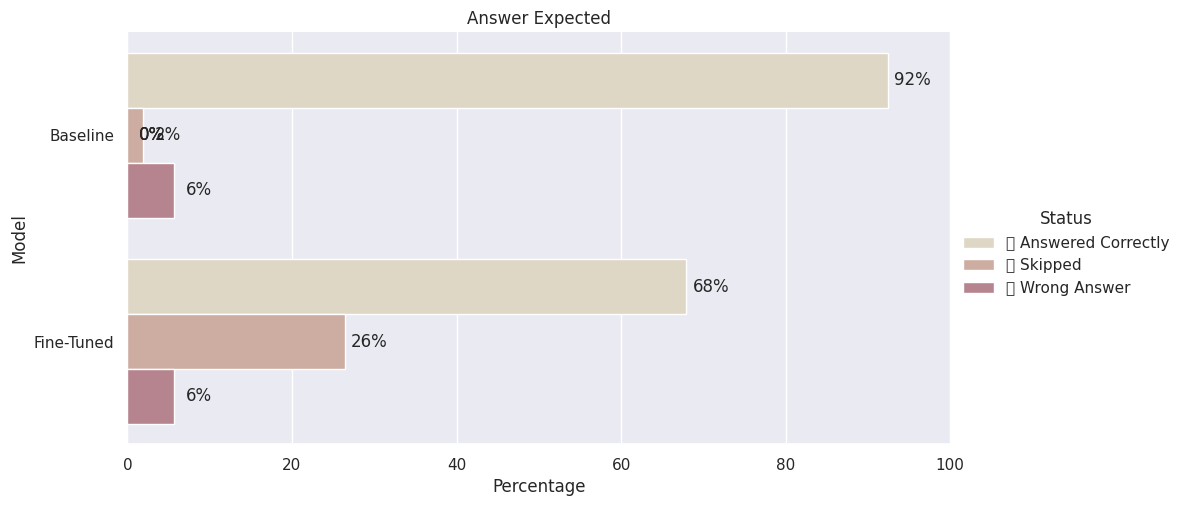

In [ ]:
evaluator.plot_evaluate_model(scenario="answer_expected")

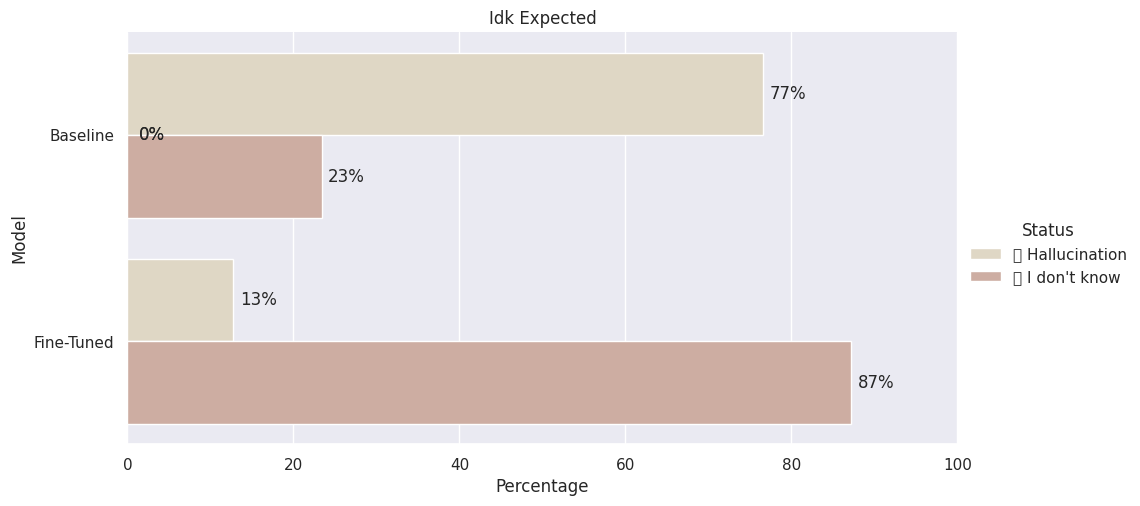

In [ ]:
evaluator.plot_evaluate_model(scenario="idk_expected")

## **4. Applying Few Shot Learning**

In [ ]:
import os
from google.colab import userdata
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

### Creating an instance of Qdrant client.

In [ ]:
qdrant_client = QdrantClient(
    url=userdata.get("qdrant_url"),
    api_key=userdata.get("qdrant"),
    timeout=6000,
    prefer_grpc=True
)

### Creating the collection in the Qdrant database.

In [ ]:
collection_name = "squadv2-cookbook"

# # Create the collection, run this only once
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

### Installing the fastembed library from the Qdrant. Fastembed allows local embedding with the CPU.

In [ ]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

100%|██████████| 76.7M/76.7M [00:01<00:00, 65.2MiB/s]


### Embed the question in the dataframe and create a new column in the dataframe named embeddings to store it. Then create a points variable to store individual point create from each row of the dataframe.

### The structure of each point

```
PointStruct(
          id = id,
          vector = embeddings,
          payload = {
              "question": question,
              "title": title,
              "context": context,
              "is_impossible": is_impossible,
              "answers": answers,
          }
      )
```

In [ ]:
def genreate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
  batch_size = 512
  questions = df["question"].tolist()
  total_batches = len(questions) // batch_size + 1

  progress_bar = tqdm(total=len(questions), desc="Generating embeddings")

  # Generating embedding in batches
  embeddings = []
  for i in range(total_batches):
    start_index = i * batch_size
    end_index = min((i+1) * batch_size, len(questions))
    batch = questions[start_index : end_index]

    # Returns the embedding
    batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)

    # Add the returned batch embedding to our list
    embeddings.extend(batch_embeddings)

    # Update progross bar by the batch size
    progress_bar.update(len(batch))

  progress_bar.close()

  # Convert from list of array to list of list
  embeddings_list = [embedding.tolist() for embedding in embeddings]

  # Create temporary DataFrame to hold the embeddings and existing DataFrame columns
  temp_df = df.copy()
  temp_df["embeddings"] = embeddings_list
  temp_df["id"] = temp_df.index

  # Generate PointStruct objects using DataFrame apply method
  points = temp_df.progress_apply(
      lambda row: PointStruct(
          id=row["id"],
          vector=row["embeddings"],
          payload={
              "question": row["question"],
              "title": row["title"],
              "context": row["context"],
              "is_impossible": row["is_impossible"],
              "answers": row["answers"],
          },
      ),
      axis=1,
  ).tolist()

  return points

In [ ]:
points = genreate_points_from_dataframe(train_df)

Generating embeddings:   0%|          | 0/130319 [00:00<?, ?it/s]

  0%|          | 0/130319 [00:00<?, ?it/s]

### An example of what a individual point looks like

In [ ]:
# This is what an element inside points look like

for element in points[0]:
  print(str(element) + "\n")

('id', 0)

('vector', [-0.020103110000491142, -0.030039820820093155, 0.04416526108980179, -0.02758147567510605, 0.0053002312779426575, 0.06449931859970093, 0.02888783998787403, 0.03356963023543358, 0.031141137704253197, -0.014485775493085384, 0.07239484786987305, 0.05670996382832527, -0.035101570188999176, -0.06548339128494263, -0.006800569128245115, 0.07952339947223663, 0.017717687413096428, -0.12317027151584625, -0.08328627794981003, -0.013064563274383545, -0.08096043765544891, 0.025316249579191208, -0.0003572077548597008, -0.04865385591983795, 0.08842404931783676, -0.020810624584555626, -0.059725236147642136, -0.01841430738568306, -0.06925289332866669, -0.11714693903923035, 0.03208290413022041, 0.044044241309165955, 0.10785617679357529, -0.014908385463058949, -0.061088114976882935, -0.008432297967374325, -0.023131322115659714, 0.019197829067707062, -0.013628384098410606, -0.019711660221219063, 0.026854710653424263, -0.017428601160645485, -0.016906101256608963, -0.09797435998916626, 

### Upload the list points to Qdrant database.

In [ ]:
# Break up the points into batches and upload the batches on to Qdrant
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def qdrant_upsert(points):
  batch_size = 100
  total_batches= len(points) // batch_size + 1
  progress_bar = tqdm(total=total_batches, desc="Uploading to Qdrant")

  for i in range(total_batches):
    batch = points[i * batch_size : min((i+1) * batch_size, len(points))]
    try:
      qdrant_client.upsert(
            collection_name=collection_name,
            wait=True,
            points=batch
      )
    except Exception as e:
      print(f"Batch {i} failed after retries: {e}")
    progress_bar.update(1)

  progress_bar.close()

In [ ]:
qdrant_upsert(points)

Uploading to Qdrant:   0%|          | 0/1304 [00:00<?, ?it/s]

True

### Given a question, using the Qdrant vector search, retreive similiar questions and their answers and include them in the same prompt.

In [ ]:
def get_few_shot_prompt(row):
  query, row_context, row_answer = row["question"], row["context"], row["answers"]

  # Embed the question
  embeddings = list(embedding_model.embed([query]))
  query_embedding = embeddings[0].tolist()

  num_of_qa_to_retrieve = 5

  # Query Qdrant for similiar question that have an answer
  q1 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = False,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve,
  )

  # Query Qdrant for similiar questions that are IMPOSSIBLE to answer
  q2 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = True,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve
  )

  instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""

  def q_to_prompt(q):
    question, context = q.payload["question"], q.payload["context"]
    answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"

    return [
        {
            "role": "user",
            "content": f"""Question: {question}\n\nContext: {context}\n\n\Answer:"""
        },
        {
            "role": "assistant",
            "content": answer
        }
    ]

  rag_prompt = []

  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[1])
  if len(q2) >= 1:
    rag_prompt += q_to_prompt(q2[1])
  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[2])

  rag_prompt += [
      {
          "role": "user",
          "content": f"""Question: {query}\n\nContent: {row_context}\n\nAnswer:"""
      },
      {
          "role": "assistant",
          "content": row_answer[0] if len(row_answer) > 0 else "I don't know"
      }
  ]

  rag_prompt = [
      {
          "role": "system",
          "content": instruction
      }
  ] + rag_prompt

  return rag_prompt

### An example what the method get_few_shot_prompt produces.

In [ ]:
example = get_few_shot_prompt(df.iloc[0])
for element in example:
  print(str(element) + "\n")

{'role': 'system', 'content': "Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"}

{'role': 'user', 'content': 'Question: For what would a bill be submitted to the Supreme Court of Scotland?\n\nContext: Royal assent is the final stage in the legislative process for acts of the Scottish parliament. The process is governed by sections 28, 32, and 33 of the Scotland Act 1998. After a bill has been passed, the Presiding Officer of the Scottish Parliament submits it to the monarch for royal assent after a four-week period, during which the Advocate General for Scotland, the Lord Advocate, the Attorney General or the Secretary of State for Scotland may refer the bill to the Supreme Court of the United Kingdom (prior to 1 October 2009, the Judicial Committee of the Privy Council) for review of its legality. Royal assent is signified by letters patent under the Great Seal of Scotland in the following fo

### Add a column in the train_sample dataframe to contain the multi-example prompts.

In [ ]:
train_sample["few_shot_prompt"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

### Formats the column "few_shot_prompt" into data that can be fine-tuned

In [ ]:
def dataframe_to_jsonl(df):
  def create_jsonl_entry(row):
    messages = row["few_shot_prompt"]
    return json.dumps({"messages": messages})

  jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
  return "\n".join(jsonl_output)

### Write the formated data into disk

In [ ]:
with open("local_cache/100_train_few_shot.jsonl", "w") as f:
  f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

### Intializing an instance of the fine tuner class.

In [ ]:
fine_tuner = openAIFineTuner(
    training_file_path = "local_cache/100_train_few_shot.jsonl",
    model_name = "gpt-3.5-turbo",
    suffix = "qdrant20240628",
    client=client
)

In [ ]:
fine_tuner.fine_tune_model()

In [ ]:
from google.colab import userdata

model_id = userdata.get("qdrant_fine_tuned")

### Using the previous get_few_shot_promot, it needed to be modified in order to leave out the last question in the prompt unanswered.

In [ ]:
def get_few_shot_prompt_non_fine_tune(row):
  query, row_context, row_answer = row["question"], row["context"], row["answers"]

  # Embed the question
  embeddings = list(embedding_model.embed([query]))
  query_embedding = embeddings[0].tolist()

  num_of_qa_to_retrieve = 5

  # Query Qdrant for similiar question that have an answer
  q1 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = False,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve,
  )

  # Query Qdrant for similiar questions that are IMPOSSIBLE to answer
  q2 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = True,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve
  )

  instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""

  def q_to_prompt(q):
    question, context = q.payload["question"], q.payload["context"]
    answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"

    return [
        {
            "role": "user",
            "content": f"""Question: {question}\n\nContext: {context}\n\n\Answer:"""
        },
        {
            "role": "assistant",
            "content": answer
        }
    ]

  rag_prompt = []

  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[1])
  if len(q2) >= 1:
    rag_prompt += q_to_prompt(q2[1])
  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[2])

  rag_prompt += [
      {
          "role": "user",
          "content": f"""Question: {query}\n\nContent: {row_context}\n\nAnswer:"""
      }
  ]

  rag_prompt = [
      {
          "role": "system",
          "content": instruction
      }
  ] + rag_prompt

  return rag_prompt

### Applying the OpenAI api calling function along with the new prompt maker, and storing the result inside ft_generated_answer_few_shot.

In [ ]:
df["ft_generated_answer_few_shot"] = df.progress_apply(answer_question, model = model_id, prompt_func = get_few_shot_prompt_non_fine_tune, axis = 1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
evaluator = Evaluator(df)

In [ ]:
df.head()

,title,question,context,is_impossible,answers,ft_generated_answer_few_shot
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,the West Lothian question
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],I don't know
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],I don't know
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],I don't know


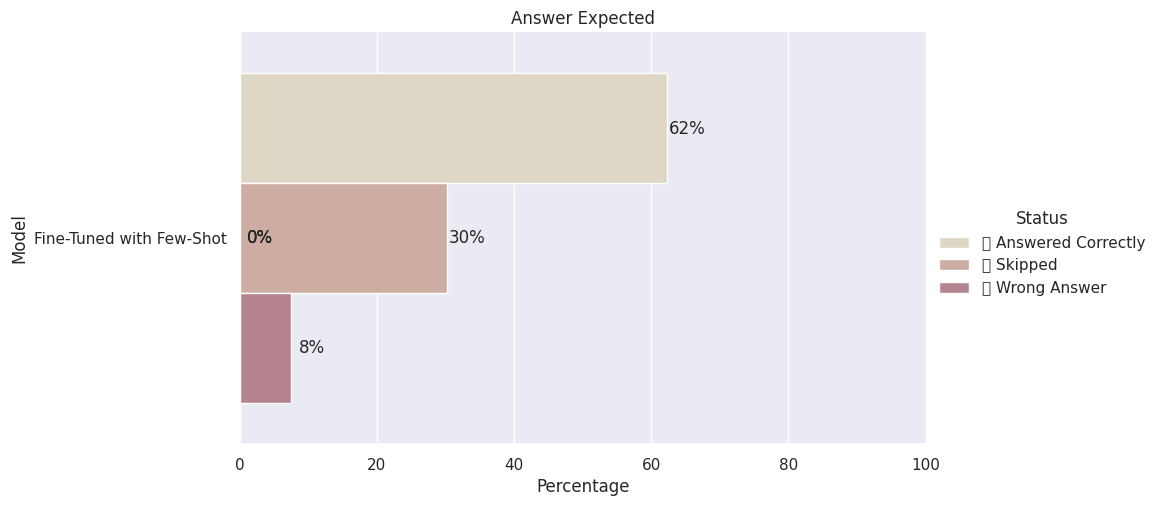

In [ ]:
evaluator.plot_evaluate_model(["ft_generated_answer_few_shot"], scenario="answer_expected", labels=["Fine-Tuned with Few-Shot"])

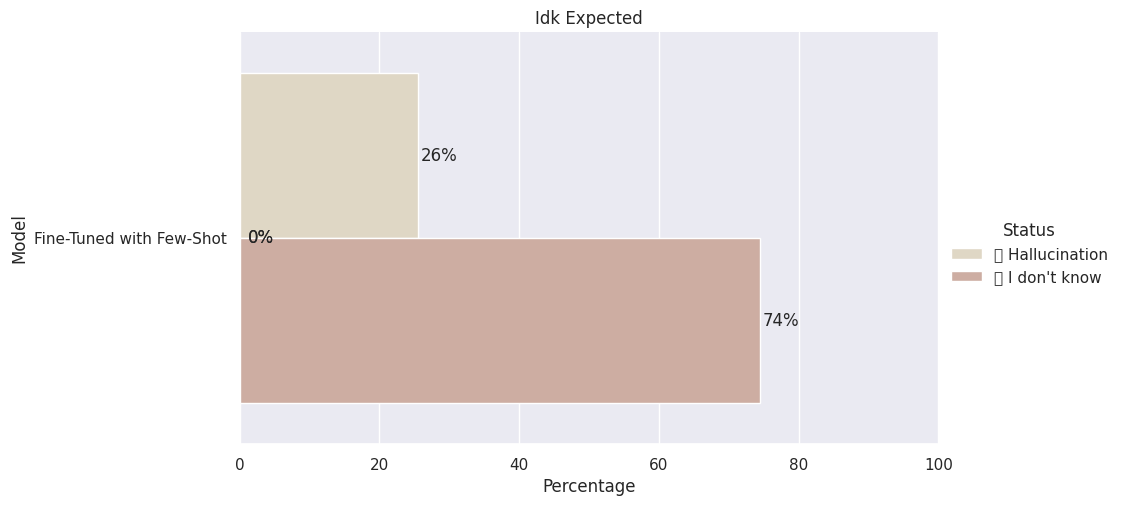

In [ ]:
evaluator.plot_evaluate_model(["ft_generated_answer_few_shot"], scenario="idk_expected", labels=["Fine-Tuned with Few-Shot"])